In [8]:
# use command line to make sure services are started (port 1883)
!brew services start mosquitto

==> Successfully started `mosquitto` (label: homebrew.mxcl.mosquitto)


In [6]:
# use command line to make sure services are stopped
!brew services stop mosquitto

Stopping `mosquitto`... (might take a while)
==> Successfully stopped `mosquitto` (label: homebrew.mxcl.mosquitto)


In [5]:
# get ip address of laptop
!ifconfig |grep "inet "

	inet 127.0.0.1 netmask 0xff000000 
	inet 192.168.2.2 netmask 0xffffff00 broadcast 192.168.2.255


In [10]:
import paho.mqtt.client as mqtt
import numpy as np


# The callback for when the client receives a CONNACK response from the server.
def on_connect(client, userdata, rc):
    print("Connected with result code "+str(rc))
    # Subscribing in on_connect() means that if we lose the connection and
    # reconnect then subscriptions will be renewed.
    client.subscribe("$ubicomp/#")
    client.subscribe("ubicomp/#")

# The callback for when a PUBLISH message is received from the server.
def on_message(client, userdata, msg):
    
    if 'ubicomp/' not in msg.topic:
        return 
    
    team = msg.topic[9:]
    msg = msg.payload
    
    print('Received', msg, 'from team',team)
    
    # now let's send something that this team might be 
    # subscribed to (randomly)
    if np.random.rand() > 0.5:
        # now send something useless!
        client.publish(topic='$SYS/Eric',payload='Hello There!')
    

client = mqtt.Client()
client.on_connect = on_connect
client.on_message = on_message

client.connect("localhost", 1883, 60)

# Blocking call that processes network traffic, dispatches callbacks and
# handles reconnecting.
# Other loop*() functions are available that give a threaded interface and a
# manual interface.
client.loop_forever()

Connected with result code 0
Received b'1540' from team instructor2
Received b'1543' from team instructor2
Received b'1534' from team instructor2
Received b'1548' from team instructor2
Received b'1546' from team instructor2
Received b'1558' from team instructor2
Received b'1567' from team instructor2
Received b'1570' from team instructor2
Received b'1567' from team instructor2
Received b'1562' from team instructor2
Received b'1559' from team instructor2
Received b'1566' from team instructor2
Received b'1557' from team instructor2
Received b'1554' from team instructor2
Received b'1564' from team instructor2
Received b'1547' from team instructor2
Received b'1548' from team instructor2
Received b'1554' from team instructor2
Received b'1557' from team instructor2
Received b'1562' from team instructor2
Received b'1585' from team instructor2
Received b'1582' from team instructor2
Received b'1558' from team instructor2
Received b'1568' from team instructor2
Received b'1565' from team instruct

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


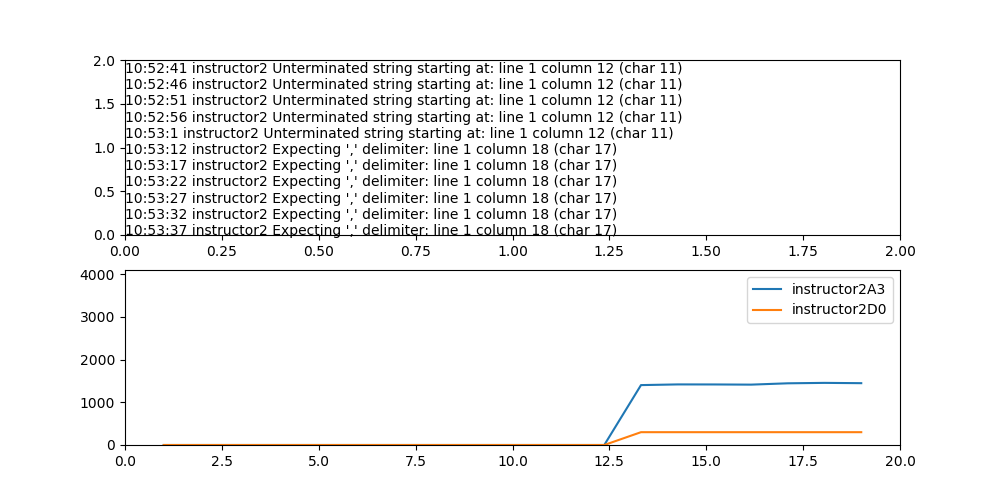

Connected with result code 0


KeyboardInterrupt: 

In [38]:
import paho.mqtt.client as mqtt
from ringbuffer import RingBuffer
import json
import numpy as np
import matplotlib
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.lines import Line2D
%matplotlib notebook

BUFFER_SIZE = 20
data = {} 
errors = ["No errors"]

# setup the figure to plot with
# fig, (ax1,ax2) = plt.subplots(1,2)

fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(2,1,1)
txt_err = ax1.text(x=0,y=0,s="No errors")
ax2 = plt.subplot(2,1,2)

# setup the plot
# setup the plot
ax1.set_xlim(0, 2)
ax1.set_ylim(0, 2)

ax2.set_xlim(0, BUFFER_SIZE)
ax2.set_ylim(0, 4096)

# The callback for when the client receives a CONNACK response from the server.
def on_connect(client, userdata, rc):
    print("Connected with result code "+str(rc))
    # Subscribing in on_connect() means that if we lose the connection and
    # reconnect then subscriptions will be renewed.
    client.subscribe("$ubicomp/#")
    client.subscribe("ubicomp/#")

# The callback for when a PUBLISH message is received from the server.
def on_message(client, userdata, msg):
    global errors
    if len(errors)>10:
        errors = errors[-10:]
            
    if 'ubicomp/' not in msg.topic:
        return 
    team='unknown'
    try:
        team = msg.topic[9:]
        payload = msg.payload

        vals = json.loads(payload)
        if team not in data:
            data[team] = {}
            for key in vals:
                data[team]['buffer'+key] = RingBuffer(BUFFER_SIZE)
                data[team]['line'+key], = plt.plot(data[team]['buffer'+key].get_samples,label=team+key)

        for key in vals:
            if 'buffer'+key not in data[team]:
                data[team]['buffer'+key] = RingBuffer(BUFFER_SIZE)
                data[team]['line'+key], = plt.plot(data[team]['buffer'+key].get_samples,label=team+key)
            
        for key in vals:
            data[team]['buffer'+key].insert_new(np.array(int(vals[key])))
            line1 = data[team]['line'+key]
            ydata = data[team]['buffer'+key].get_samples
            line1.set_xdata(np.linspace(1,BUFFER_SIZE-1,BUFFER_SIZE))
            line1.set_ydata(ydata)  # set the data
        plt.draw()  # and draw it out
        plt.legend()
        fig.canvas.draw()  # pause so that the drawing updates 

        # now let's send something that this team might be 
        # subscribed to (randomly)
        #if np.random.rand() > 0.5:
        val = 'OFF' if np.random.rand() > 0.5 else 'ON'
        client.publish(topic='$'+team,payload='LED '+val)
            
    except Exception as inst: 
        
        #print(team,inst)
        
        now = datetime.now()
        
        errs_str = '%s:%s:%s' % (now.hour, now.minute, now.second)+' '+str(team)+' '+str(inst)
        errors += [errs_str]
        
        to_display = '\n'.join(errors)
        txt_err.set_text(to_display)
        plt.draw()  # and draw it out
        fig.canvas.draw()  # pause so that the drawing updates 
        client.publish(topic='$'+team,payload=str(inst))

client = mqtt.Client()
client.on_connect = on_connect
client.on_message = on_message

client.connect("localhost", 1883, 60)

# Blocking call that processes network traffic, dispatches callbacks and
# handles reconnecting.
# Other loop*() functions are available that give a threaded interface and a
# manual interface.
client.loop_forever()

In [37]:
client.disconnect()

4